# Large Language Model Project

## Dataset Description


The challenge in this competition is to answer multiple-choice questions written by an LLM. While the specifics of the process used to generate these questions aren't public, we've included 200 sample questions with answers to show the format, and to give a general sense of the kind of questions in the test set. However, there may be a distributional shift between the sample questions and the test set, so solutions that generalize to a broad set of questions are likely to perform better. Each question consists of a prompt (the question), 5 options labeled A, B, C, D, and E, and the correct answer labeled answer (this holds the label of the most correct answer, as defined by the generating LLM).

 The test set has the same format as the provided test.csv but has ~4000 questions that may be different is subject matter.

**Files**
- **train.csv** - a set of 200 questions with the answer column
- **test.csv** - the test set; your task it to predict the top three most probable answers given the prompt. NOTE: the test data you see here just a copy of the training data without the answers. The unseen re-run test set is comprised of ~4,000 different prompts.
- **sample_submission.csv** - a sample submission file in the correct format

**Columns**
- **prompt** - the text of the question being asked
- A - option A; if this option is correct, then answer will be A
- B - option B; if this option is correct, then answer will be B
- C - option C; if this option is correct, then answer will be C
- D - option D; if this option is correct, then answer will be D
- E - option E; if this option is correct, then answer will be E
- **answer** - the most correct answer, as defined by the generating LLM (one of A, B, C, D, or E).

In [53]:
pip install wordcloud

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Note: you may need to restart the kernel to use updated packages.


In [54]:
pip install --upgrade Pillow

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Note: you may need to restart the kernel to use updated packages.


In [55]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

In [56]:
df_train = pd.read_csv("train.csv")

In [57]:
df_train.head()

,id,prompt,A,B,C,D,E,answer
0,0,Which of the following statements accurately d...,MOND is a theory that reduces the observed mis...,MOND is a theory that increases the discrepanc...,MOND is a theory that explains the missing bar...,MOND is a theory that reduces the discrepancy ...,MOND is a theory that eliminates the observed ...,D
1,1,Which of the following is an accurate definiti...,Dynamic scaling refers to the evolution of sel...,Dynamic scaling refers to the non-evolution of...,Dynamic scaling refers to the evolution of sel...,Dynamic scaling refers to the non-evolution of...,Dynamic scaling refers to the evolution of sel...,A
2,2,Which of the following statements accurately d...,The triskeles symbol was reconstructed as a fe...,The triskeles symbol is a representation of th...,The triskeles symbol is a representation of a ...,The triskeles symbol represents three interloc...,The triskeles symbol is a representation of th...,A
3,3,What is the significance of regularization in ...,Regularizing the mass-energy of an electron wi...,Regularizing the mass-energy of an electron wi...,Regularizing the mass-energy of an electron wi...,Regularizing the mass-energy of an electron wi...,Regularizing the mass-energy of an electron wi...,C
4,4,Which of the following statements accurately d...,The angular spacing of features in the diffrac...,The angular spacing of features in the diffrac...,The angular spacing of features in the diffrac...,The angular spacing of features in the diffrac...,The angular spacing of features in the diffrac...,D


In [58]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      200 non-null    int64 
 1   prompt  200 non-null    object
 2   A       200 non-null    object
 3   B       200 non-null    object
 4   C       200 non-null    object
 5   D       200 non-null    object
 6   E       200 non-null    object
 7   answer  200 non-null    object
dtypes: int64(1), object(7)
memory usage: 12.6+ KB


In [59]:
question1 = df_train['prompt'][0]
print(question1)

Which of the following statements accurately describes the impact of Modified Newtonian Dynamics (MOND) on the observed "missing baryonic mass" discrepancy in galaxy clusters?


In [60]:
answer1 = df_train['answer'][0]
print(answer1)

D


In [61]:
full_answer1 = df_train[answer1][0]
print(full_answer1)

MOND is a theory that reduces the discrepancy between the observed missing baryonic mass in galaxy clusters and the measured velocity dispersions from a factor of around 10 to a factor of about 2.


In [62]:
#number of rows and columns
df_train.shape

(200, 8)

In [63]:
df_train['answer'].nunique()

5

In [64]:
answer_values = df_train['answer'].value_counts().values
answer_values

array([48, 44, 38, 37, 33])

In [65]:
answer_indices = df_train['answer'].value_counts().index
answer_indices

Index(['B', 'C', 'D', 'A', 'E'], dtype='object')

In [66]:
answer_distribution = df_train['answer'].value_counts()

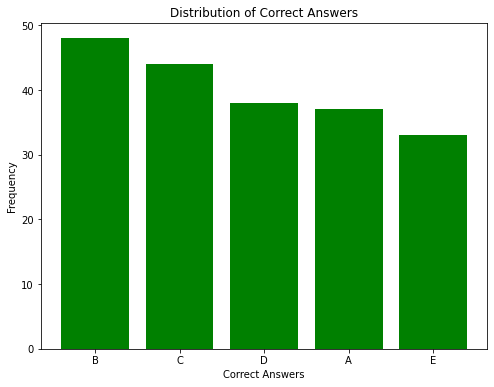

In [67]:
# Create a bar chart
plt.figure(figsize=(8, 6))
plt.bar(answer_distribution.index, answer_distribution.values, color='green')
plt.xlabel('Correct Answers')
plt.ylabel('Frequency')
plt.title('Distribution of Correct Answers')
plt.show()

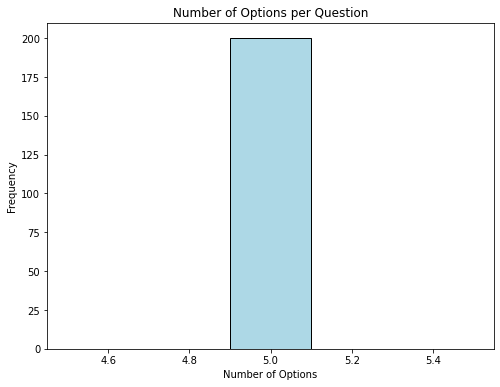

In [68]:
# Calculate the number of options per question
df_train['num_options'] = df_train[['A', 'B', 'C', 'D', 'E']].notnull().sum(axis=1)

# Create a histogram
plt.figure(figsize=(8, 6))
plt.hist(df_train['num_options'], bins=5, color='lightblue', edgecolor='black')
plt.xlabel('Number of Options')
plt.ylabel('Frequency')
plt.title('Number of Options per Question')
plt.show()

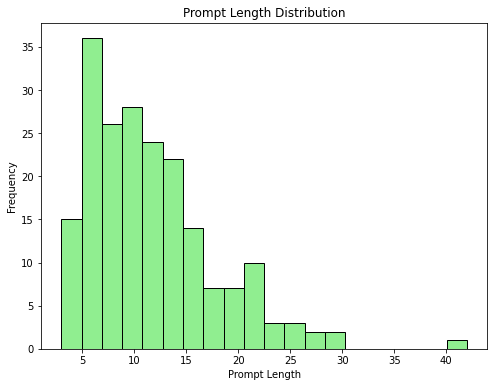

In [69]:
# Calculate the length of prompts (number of words)
df_train['prompt_length'] = df_train['prompt'].apply(lambda x: len(x.split()))

# Create a histogram
plt.figure(figsize=(8, 6))
plt.hist(df_train['prompt_length'], bins=20, color='lightgreen', edgecolor='black')
plt.xlabel('Prompt Length')
plt.ylabel('Frequency')
plt.title('Prompt Length Distribution')
plt.show()

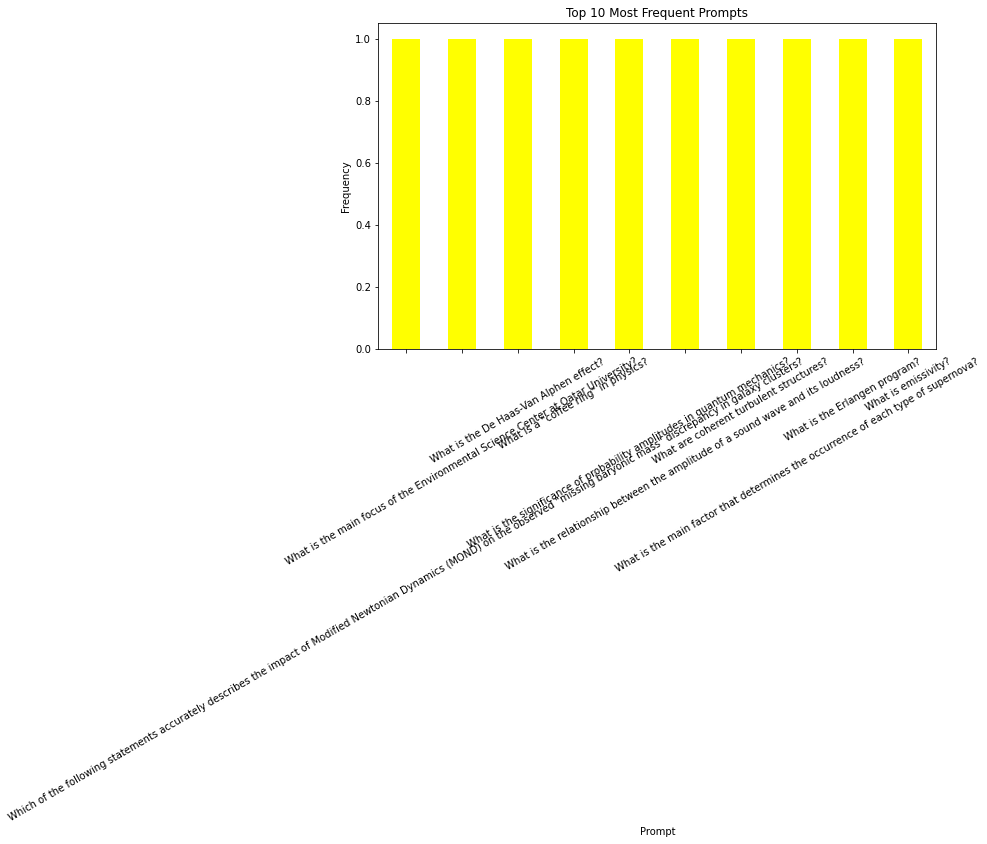

In [70]:
# Calculate the top N most frequent prompts
top_prompts = df_train['prompt'].value_counts().head(10)

# Create a bar chart
plt.figure(figsize=(10, 6))
top_prompts.plot(kind='bar', color='yellow')
plt.xlabel('Prompt')
plt.ylabel('Frequency')
plt.title('Top 10 Most Frequent Prompts')
plt.xticks(rotation=30)
plt.show()

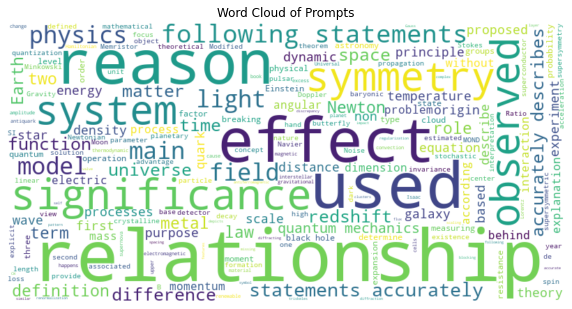

In [71]:
from wordcloud import WordCloud

# Combine all prompts into a single text
all_prompts_text = ' '.join(df_train['prompt'])

# Generate a word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_prompts_text)

# Display the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Prompts')
plt.show()

In [72]:
conda create -n env_pytorch python=3.6 -y

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Solving environment: failed with repodata from current_repodata.json, will retry with next repodata source.
Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 22.9.0
  latest version: 23.7.3

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /Users/guy.biyogmam/opt/anaconda3/envs/env_pytorch

  added / updated specs:
    - python=3.6


The following NEW packages will be INSTALLED:

  ca-certificates    pkgs/main/osx-64::ca-certificates-2023.08.22-hecd8cb5_0 None
  certifi            pkgs/main/osx-64::certifi-2021.5.30-py36hecd8cb5_0 None
  libcxx    

In [73]:
pip install torchvision 

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Note: you may need to restart the kernel to use updated packages.


In [74]:
import torch

In [75]:
pip install transformers

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Note: you may need to restart the kernel to use updated packages.


In [76]:
import pandas as pd
from string import Template
from pathlib import Path
import warnings
warnings.simplefilter("ignore")

from transformers import T5Tokenizer, T5ForConditionalGeneration

In [77]:
data_path = Path('test.csv')
llm = "google/flan-t5-small"

In [78]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
model = AutoModelForSeq2SeqLM.from_pretrained("google/flan-t5-small").to(device)
tokenizer = AutoTokenizer.from_pretrained("google/flan-t5-small")

In [79]:
test = pd.read_csv('test.csv', index_col='id')

test.head()

,prompt,A,B,C,D,E
id,,,,,,
0,Which of the following statements accurately d...,MOND is a theory that reduces the observed mis...,MOND is a theory that increases the discrepanc...,MOND is a theory that explains the missing bar...,MOND is a theory that reduces the discrepancy ...,MOND is a theory that eliminates the observed ...
1,Which of the following is an accurate definiti...,Dynamic scaling refers to the evolution of sel...,Dynamic scaling refers to the non-evolution of...,Dynamic scaling refers to the evolution of sel...,Dynamic scaling refers to the non-evolution of...,Dynamic scaling refers to the evolution of sel...
2,Which of the following statements accurately d...,The triskeles symbol was reconstructed as a fe...,The triskeles symbol is a representation of th...,The triskeles symbol is a representation of a ...,The triskeles symbol represents three interloc...,The triskeles symbol is a representation of th...
3,What is the significance of regularization in ...,Regularizing the mass-energy of an electron wi...,Regularizing the mass-energy of an electron wi...,Regularizing the mass-energy of an electron wi...,Regularizing the mass-energy of an electron wi...,Regularizing the mass-energy of an electron wi...
4,Which of the following statements accurately d...,The angular spacing of features in the diffrac...,The angular spacing of features in the diffrac...,The angular spacing of features in the diffrac...,The angular spacing of features in the diffrac...,The angular spacing of features in the diffrac...


In [80]:
preamble = 'Answer the following question...'
template = Template('$preamble\n\n$prompt\n\nA) $a\nB) $b\nC) $c\nD) $d\nE) $e')

def format_input(df, idx):
    prompt = df.loc[idx, 'prompt']
    a = df.loc[idx, 'A']
    b = df.loc[idx, 'B']
    c = df.loc[idx, 'C']
    d = df.loc[idx, 'D']
    e = df.loc[idx, 'E']

    input_text = template.substitute(
        preamble=preamble, prompt=prompt, a=a, b=b, c=c, d=d, e=e)
    
    return input_text
print(format_input(test, 0))

Answer the following question...

Which of the following statements accurately describes the impact of Modified Newtonian Dynamics (MOND) on the observed "missing baryonic mass" discrepancy in galaxy clusters?

A) MOND is a theory that reduces the observed missing baryonic mass in galaxy clusters by postulating the existence of a new form of matter called "fuzzy dark matter."
B) MOND is a theory that increases the discrepancy between the observed missing baryonic mass in galaxy clusters and the measured velocity dispersions from a factor of around 10 to a factor of about 20.
C) MOND is a theory that explains the missing baryonic mass in galaxy clusters that was previously considered dark matter by demonstrating that the mass is in the form of neutrinos and axions.
D) MOND is a theory that reduces the discrepancy between the observed missing baryonic mass in galaxy clusters and the measured velocity dispersions from a factor of around 10 to a factor of about 2.
E) MOND is a theory that 

In [81]:
inputs = tokenizer(format_input(test, 1), return_tensors="pt").to(device)
outputs = model.generate(**inputs)
answer = tokenizer.batch_decode(outputs, skip_special_tokens=True)

print(answer)

['C']


In [82]:
def post_process(predictions):
    valid = set(['A', 'B', 'C', 'D', 'E'])
    # If there are no valid choices, return something and hope for partial credit
    if set(predictions).isdisjoint(valid):
        final_pred = 'A B C D E'
    else:
        final_pred = []
        for prediction in predictions:
            if prediction in valid:
                final_pred += prediction
        # add remaining letters
        to_add = valid - set(final_pred)
        final_pred.extend(list(to_add))
        # put in space-delimited format
        final_pred = ' '.join(final_pred)
        
    return final_pred

In [83]:
submission = pd.read_csv('sample_submission.csv', index_col='id')

for idx in test.index:
    inputs = tokenizer(format_input(test, idx), return_tensors="pt").to(device)
    outputs = model.generate(**inputs)
    answer = tokenizer.batch_decode(outputs, skip_special_tokens=True)
    submission.loc[idx, 'prediction'] = post_process(answer)

Token indices sequence length is longer than the specified maximum sequence length for this model (564 > 512). Running this sequence through the model will result in indexing errors


In [84]:
submission.head()

,prediction
id,
0,D B A C E
1,C D A B E
2,B D A C E
3,C D A B E
4,B D A C E
